In [ ]:
# Por inconvenientes con las sesiones del colab, tuve que trabajar directamente en mi computador todo el ejercicio.

from shutil import copyfile
import os

drive_path = '/media/camilo/Data/udea-specialization/monografia'
base_path = os.path.join(drive_path, 'final')
iter_path = os.path.join(base_path, 'iter2')
data_path = os.path.join(iter_path, 'data')
models_path = os.path.join(iter_path, 'models')

if not os.path.exists(data_path):
    os.makedirs(data_path)

if not os.path.exists(models_path):
    os.makedirs(models_path)

# drive.mount(drive_path, force_remount=True)
%cd $data_path

/media/camilo/Data/udea-specialization/monografia/final/iter2/data


In [ ]:
#Data management Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import random
import shutil

# Data Modeling Libraries
from keras.models import save_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Activation, Dropout, Flatten, Dense, Input, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

In [ ]:
# Ruta de la carpeta raiz
root_path = data_path

# Ruta de la carpeta raiz para train
train_set_root_path = os.path.join(root_path,'training_set')

# Ruta de la carpeta raiz para train
val_set_root_path = os.path.join(root_path,'val_set')

# Ruta de la carpeta raiz para test
test_set_root_path = os.path.join(root_path,'test_set')


In [ ]:
print("Train Dataset")
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
train_dataset = train_generator.flow_from_directory(train_set_root_path,
                                                        target_size = (224, 224),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

print("Validation Dataset")
val_generator = ImageDataGenerator(rescale=1./255)
val_dataset = val_generator.flow_from_directory(val_set_root_path,
                                                 target_size = (224, 224),
                                                 batch_size = 1,
                                                 class_mode = 'categorical',
                                                 shuffle = False)

print("Test Dataset")
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(test_set_root_path,
                                                 target_size = (224, 224),
                                                 batch_size = 1,
                                                 class_mode = 'categorical',
                                                 shuffle = False)

Train Dataset
Found 5615 images belonging to 21 classes.
Validation Dataset
Found 1404 images belonging to 21 classes.
Test Dataset
Found 1755 images belonging to 21 classes.


In [ ]:
def get_class_weight_folder(path, class_indices):
    class_weight = {}
    total_files = 0
    for root, dirs, files in os.walk(path):
        if root is not path:
            folder = root.split(os.sep)[-1]
            files_count = len(files)
            class_index = class_indices[folder]
            class_weight[class_index] = files_count
            total_files += files_count

    for key in class_weight.keys():
        class_weight[key] = class_weight[key]/total_files

    return class_weight

movement_weights = get_class_weight_folder(train_set_root_path, train_dataset.class_indices)

In [ ]:
def fit_eval_save(model, train_dataset, val_dataset, test_dataset, model_name="model", callbacks=None, class_weight=None, epochs = 30):
    
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks, class_weight=movement_weights)

    tf.keras.utils.plot_model(model, show_shapes=True) 
       
    y11 = history.history["val_accuracy"]
    y12 = history.history["accuracy"]
    x1 = range(len(y11))

    plt.plot(x1, y11)
    plt.plot(x1, y12)

    plt.legend(["Validation", "Test"])
    plt.title("Accuracy through Epochs")

    y_pred = history.model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis = 1)

    clases = list(test_dataset.class_indices.keys())
    abr_clases = ["".join([(w[:3]) for w in name.split()]) for name in clases]
    y_test = test_dataset.classes

    fig, ax = plt.subplots(figsize=(15, 15))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=clases,ax=ax, cmap='Blues', normalize="true")
    ax.xaxis.set_ticklabels(abr_clases)
    plt.show()

    print(classification_report(y_test,y_pred, target_names=clases))

    model_json = model.to_json()
    with open(os.path.join(models_path,f'{model_name}_model.json'),'w') as json_file:
        json_file.write(model_json)

    save_model(model, os.path.join(models_path,f'{model_name}_weights.hdf5'))



### Baseline

ConvNN + Avg Pooling + 3 Capas densas

15 Epochs


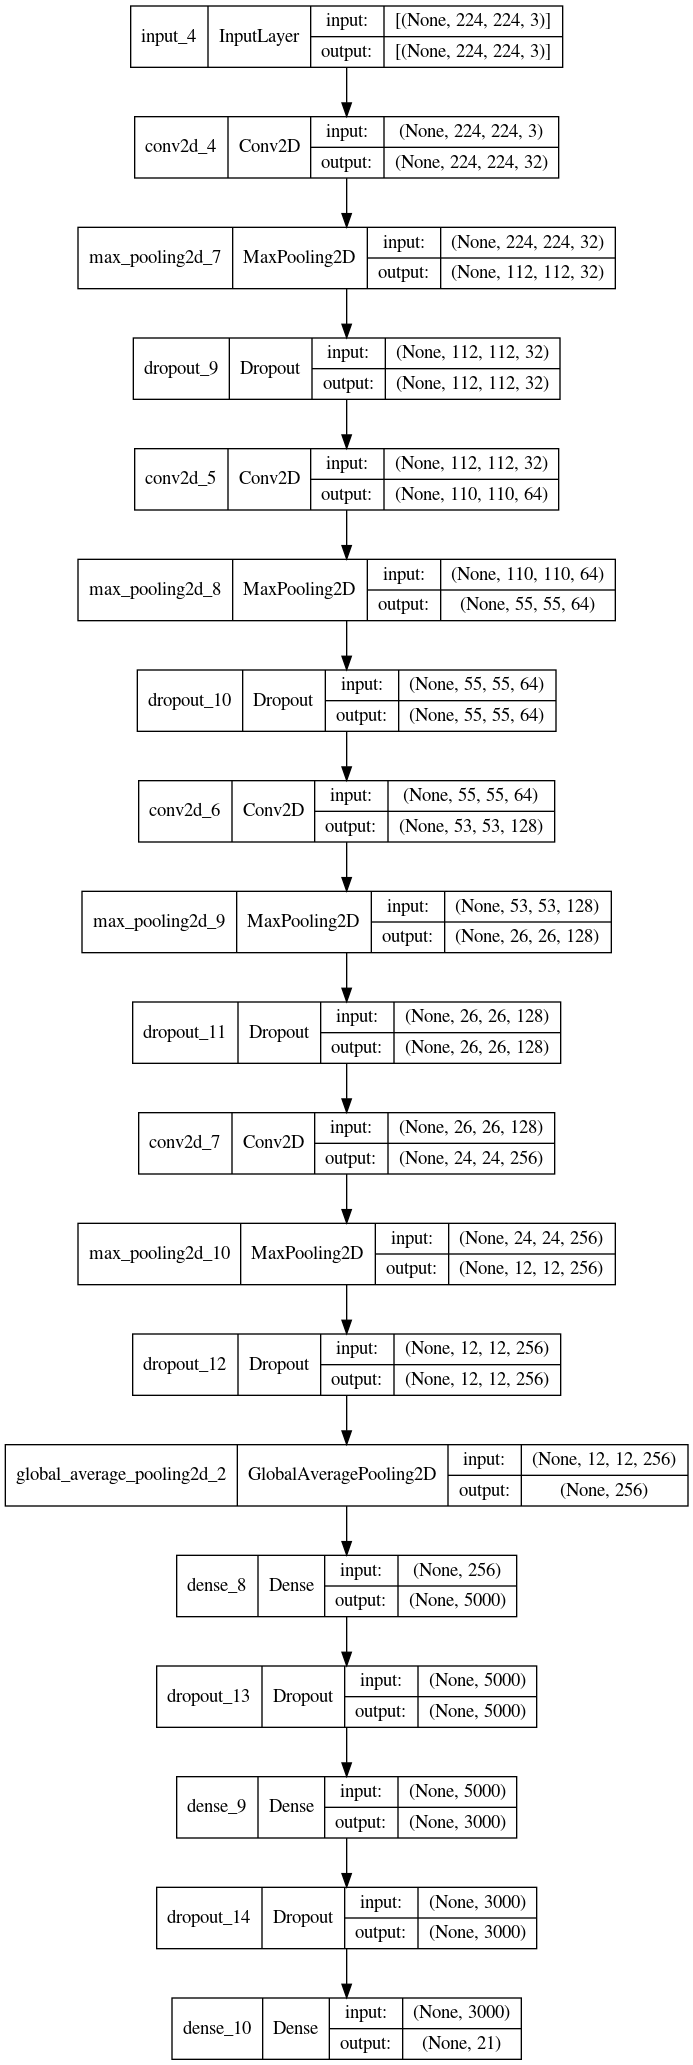

In [ ]:

inputs = tf.keras.Input(shape=(224,224,3))
baseline_model = Conv2D(32, (3,3), activation='relu', padding ='same', kernel_initializer= 'he_normal')(inputs)
baseline_model = MaxPooling2D((2,2))(baseline_model)
baseline_model = Dropout(rate = 0.2)(baseline_model)
baseline_model = Conv2D(64, (3,3), activation='relu')(baseline_model)
baseline_model = MaxPooling2D((2,2))(baseline_model)
baseline_model = Dropout(rate = 0.2)(baseline_model)
baseline_model = Conv2D(128, (3,3), activation='relu')(baseline_model)
baseline_model = MaxPooling2D((2,2))(baseline_model)
baseline_model = Dropout(rate = 0.2)(baseline_model)
baseline_model = Conv2D(256, (3,3), activation='relu')(baseline_model)
baseline_model = MaxPooling2D((2,2))(baseline_model)
baseline_model = Dropout(rate = 0.2)(baseline_model)
baseline_model = GlobalAveragePooling2D()(baseline_model)
baseline_model = Dense(units = 5000, activation='relu')(baseline_model)
baseline_model = Dropout(rate = 0.5)(baseline_model)
baseline_model = Dense(units = 3000, activation='relu')(baseline_model)
baseline_model = Dropout(rate = 0.5)(baseline_model)
baseline_model = Dense(21, activation='softmax')(baseline_model)

model = Model(inputs = inputs, outputs = baseline_model)

early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=True)
callbacks = [early_stopping]

model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
351/351 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.1929WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe81cb0cd90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

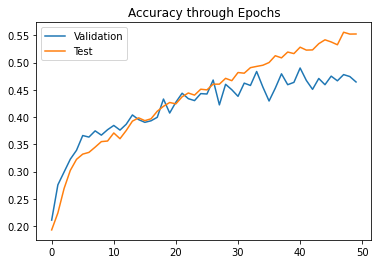

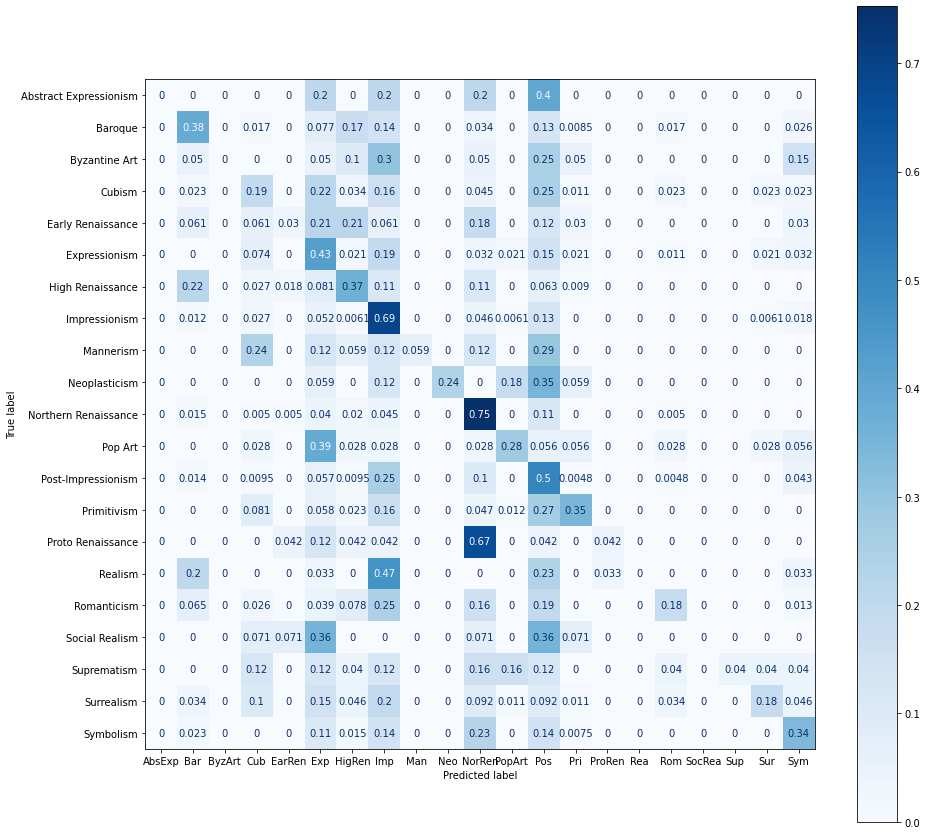

/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Abstract Expressionism       0.00      0.00      0.00         5
               Baroque       0.45      0.38      0.41       117
         Byzantine Art       0.00      0.00      0.00        20
                Cubism       0.24      0.19      0.22        88
     Early Renaissance       0.17      0.03      0.05        33
         Expressionism       0.21      0.43      0.28        94
      High Renaissance       0.41      0.37      0.39       111
         Impressionism       0.51      0.69      0.58       329
             Mannerism       1.00      0.06      0.11        17
         Neoplasticism       1.00      0.24      0.38        17
  Northern Renaissance       0.51      0.75      0.61       202
               Pop Art       0.43      0.28      0.34        36
    Post-Impressionism       0.32      0.50      0.39       210
           Primitivism       0.68      0.35      0.46        86
     Proto Renaissance       0.50      

In [ ]:
fit_eval_save(model, train_dataset, val_dataset, test_dataset, "cnn_from_scratch", callbacks, movement_weights, 50)

### Modelo 1

ResNet152 V2 (No entrenable) + Avg Pooling + 3 Capas densas

15 Epochs


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.526225 to fit



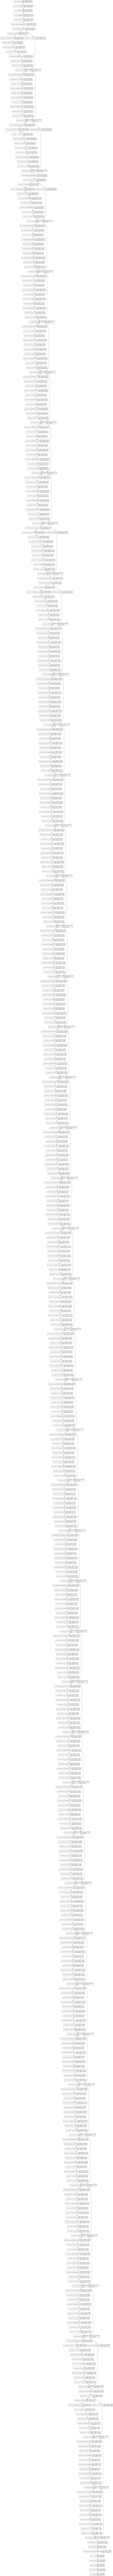

In [ ]:
base_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, 
                                               input_tensor = Input(shape = (224, 224, 3)))

for layer in base_model.layers:
  layer.trainable = False

head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 5000, activation='relu')(head_model)
head_model = Dropout(rate = 0.5)(head_model)
head_model = Dense(units = 3000, activation='relu')(head_model)
head_model = Dropout(rate = 0.5)(head_model)
head_model = Dense(21, activation='softmax')(head_model)

model = Model(inputs = base_model.input, outputs = head_model)

early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=True)
callbacks = [early_stopping]

model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
351/351 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.3289WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe8b8ec59d8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

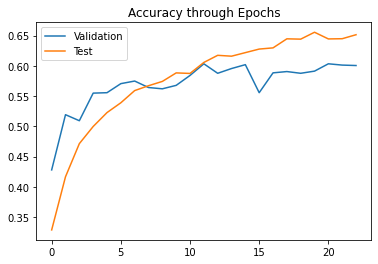

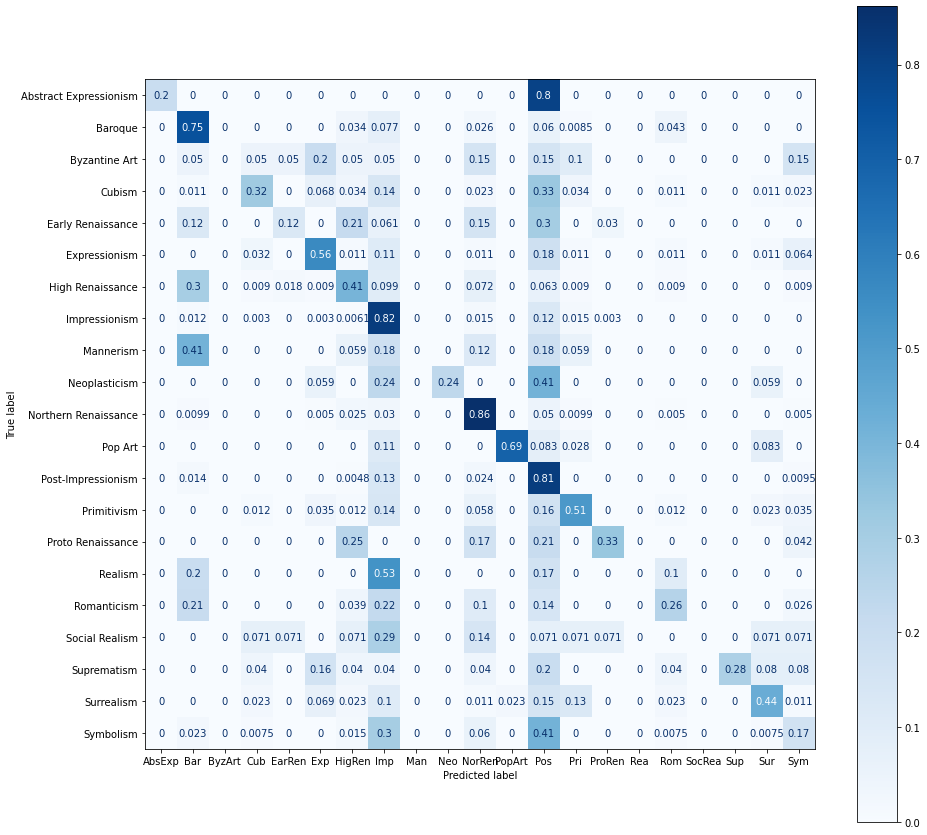

/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-p

                        precision    recall  f1-score   support

Abstract Expressionism       1.00      0.20      0.33         5
               Baroque       0.52      0.75      0.62       117
         Byzantine Art       0.00      0.00      0.00        20
                Cubism       0.70      0.32      0.44        88
     Early Renaissance       0.50      0.12      0.20        33
         Expressionism       0.66      0.56      0.61        94
      High Renaissance       0.52      0.41      0.46       111
         Impressionism       0.59      0.82      0.69       329
             Mannerism       0.00      0.00      0.00        17
         Neoplasticism       1.00      0.24      0.38        17
  Northern Renaissance       0.73      0.86      0.79       202
               Pop Art       0.93      0.69      0.79        36
    Post-Impressionism       0.41      0.81      0.54       210
           Primitivism       0.60      0.51      0.55        86
     Proto Renaissance       0.73      

In [ ]:
fit_eval_save(model, train_dataset, val_dataset, test_dataset, "restnet_vanila", callbacks, movement_weights)

### Modelo 2

ResNet152 V2 (Primeras 450 capas No entrenables) + Avg Pooling + 3 Capas densas

15 Epochs


In [ ]:
base_model.trainable = True

fine_tuning_at = 450

for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
351/351 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.2997WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe8b815a400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

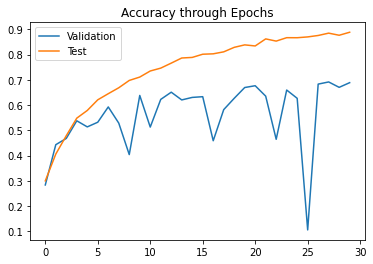

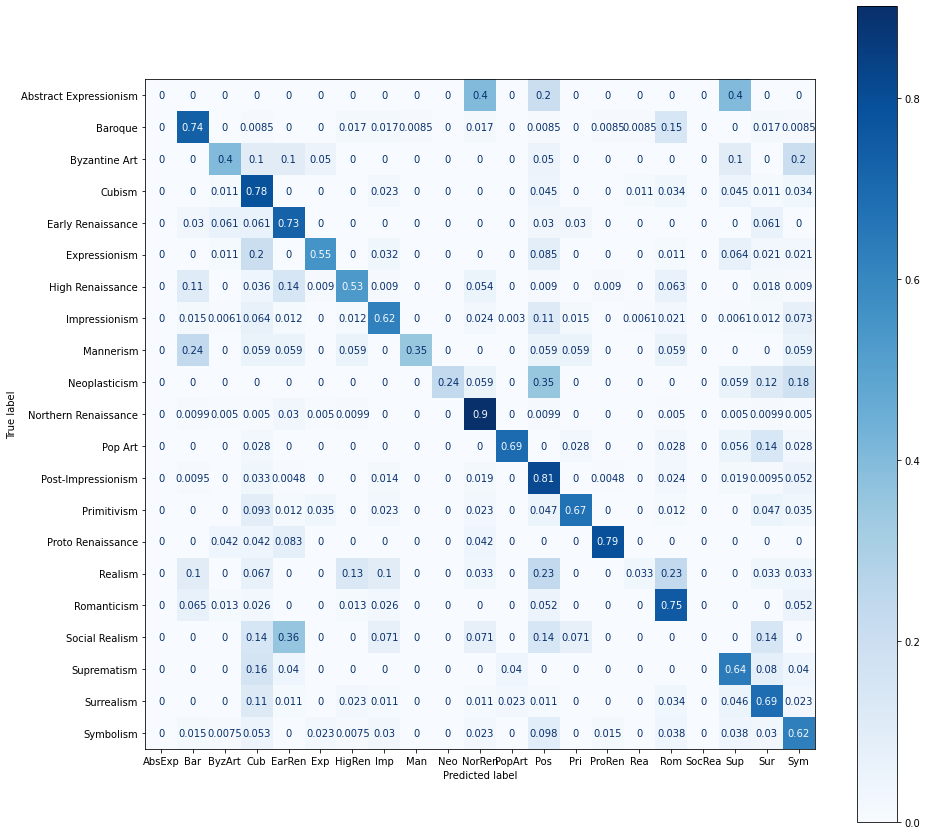

/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-p

                        precision    recall  f1-score   support

Abstract Expressionism       0.00      0.00      0.00         5
               Baroque       0.70      0.74      0.72       117
         Byzantine Art       0.44      0.40      0.42        20
                Cubism       0.42      0.78      0.55        88
     Early Renaissance       0.38      0.73      0.49        33
         Expressionism       0.85      0.55      0.67        94
      High Renaissance       0.78      0.53      0.63       111
         Impressionism       0.89      0.62      0.73       329
             Mannerism       0.86      0.35      0.50        17
         Neoplasticism       1.00      0.24      0.38        17
  Northern Renaissance       0.85      0.90      0.88       202
               Pop Art       0.86      0.69      0.77        36
    Post-Impressionism       0.65      0.81      0.72       210
           Primitivism       0.87      0.67      0.76        86
     Proto Renaissance       0.79      

In [ ]:
fit_eval_save(model, train_dataset, val_dataset, test_dataset, "restnet_finetuning_450_notr", callbacks, movement_weights)

### Modelo 3

ResNet152 V2 (Unicamente últimas 30 capas entrenables) + Avg Pooling + 3 Capas densas

15 Epochs


In [ ]:
base_model.trainable = False

fine_tuning_last = 30 

for layer in base_model.layers[-fine_tuning_last:]:
  layer.trainable = True
  
model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
351/351 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9079WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe859fb5b70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

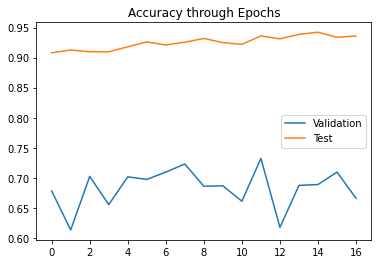

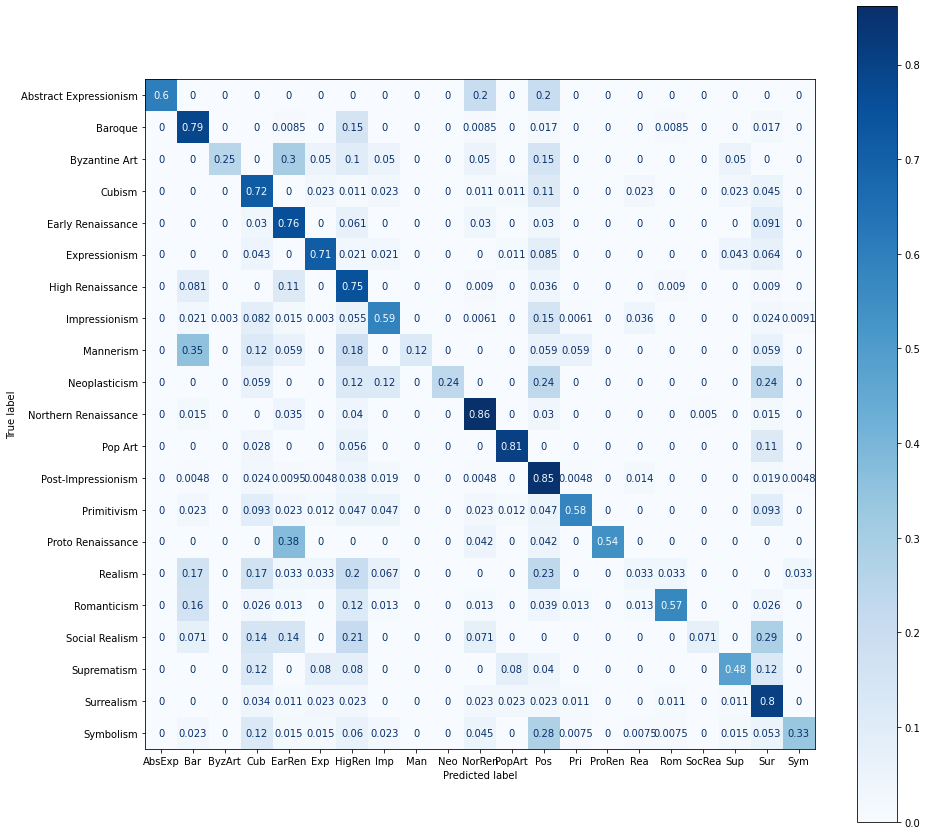

                        precision    recall  f1-score   support

Abstract Expressionism       1.00      0.60      0.75         5
               Baroque       0.65      0.79      0.71       117
         Byzantine Art       0.83      0.25      0.38        20
                Cubism       0.44      0.72      0.55        88
     Early Renaissance       0.32      0.76      0.45        33
         Expressionism       0.84      0.71      0.77        94
      High Renaissance       0.45      0.75      0.56       111
         Impressionism       0.90      0.59      0.71       329
             Mannerism       1.00      0.12      0.21        17
         Neoplasticism       1.00      0.24      0.38        17
  Northern Renaissance       0.89      0.86      0.87       202
               Pop Art       0.81      0.81      0.81        36
    Post-Impressionism       0.55      0.85      0.67       210
           Primitivism       0.88      0.58      0.70        86
     Proto Renaissance       1.00      

/home/camilo/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
fit_eval_save(model, train_dataset, val_dataset, test_dataset, "restnet_finetuning_last30_tr", callbacks, movement_weights)

### Modelo 4

ResNet152 V2 (Completamente entrenable) + Avg Pooling + 3 Capas densas

15 Epochs


Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
351/351 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.2825WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe8461c18c8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

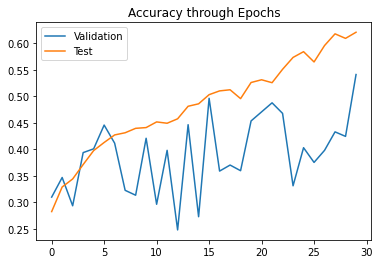

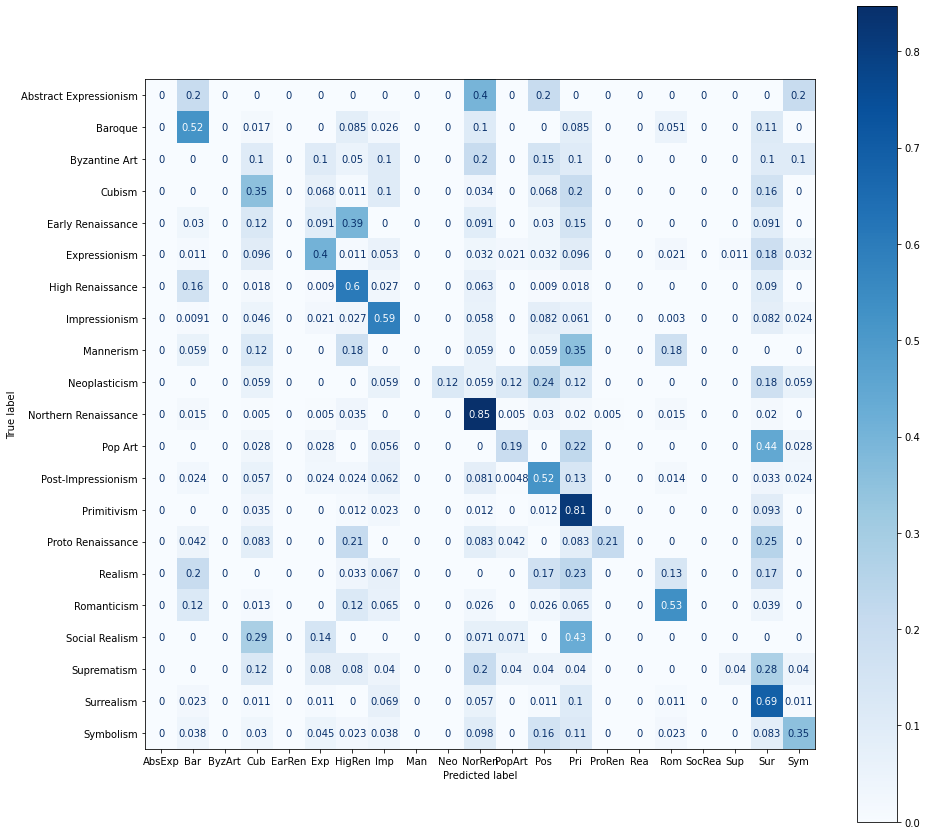

/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-p

                        precision    recall  f1-score   support

Abstract Expressionism       0.00      0.00      0.00         5
               Baroque       0.52      0.52      0.52       117
         Byzantine Art       0.00      0.00      0.00        20
                Cubism       0.31      0.35      0.33        88
     Early Renaissance       0.00      0.00      0.00        33
         Expressionism       0.51      0.40      0.45        94
      High Renaissance       0.49      0.60      0.54       111
         Impressionism       0.77      0.59      0.66       329
             Mannerism       0.00      0.00      0.00        17
         Neoplasticism       1.00      0.12      0.21        17
  Northern Renaissance       0.63      0.85      0.72       202
               Pop Art       0.44      0.19      0.27        36
    Post-Impressionism       0.56      0.52      0.54       210
           Primitivism       0.31      0.81      0.44        86
     Proto Renaissance       0.83      

In [ ]:
base_model.trainable = True

model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

fit_eval_save(model, train_dataset, val_dataset, test_dataset, "restnet_finetuning_all_tr", callbacks, movement_weights)

### Modelo 5

VGG19 (No Entrenable)  + 2 Capas densas



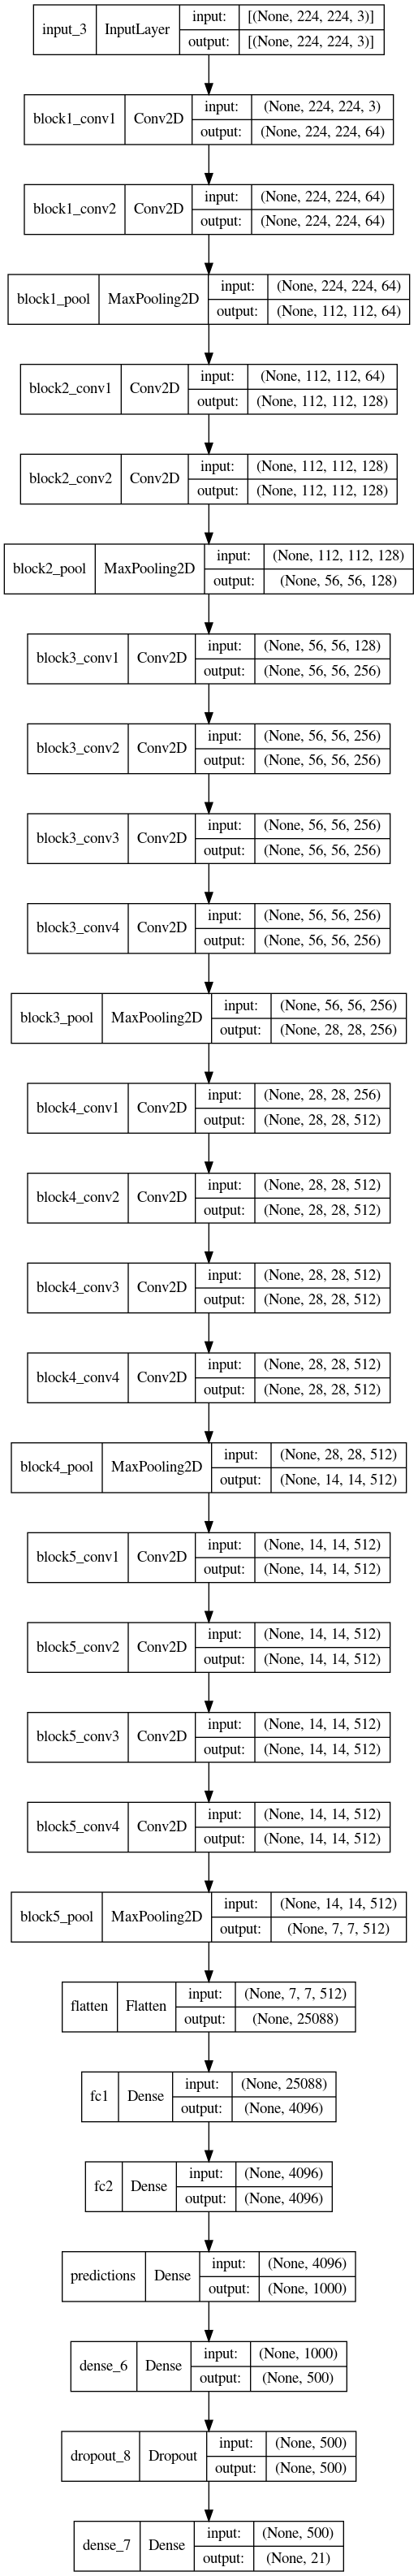

In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor = Input(shape = (224, 224, 3)),
    pooling=None,
    classes=1000,
)

base_model.trainable = False

vgg_model = base_model.output
vgg_model = Dense(units = 500, activation='relu')(vgg_model)
vgg_model = Dropout(rate = 0.5)(vgg_model)
vgg_model = Dense(21, activation='softmax')(vgg_model)


model = Model(inputs = base_model.input, outputs = vgg_model)

early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)


Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
351/351 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.1856WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe8cc94a730> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

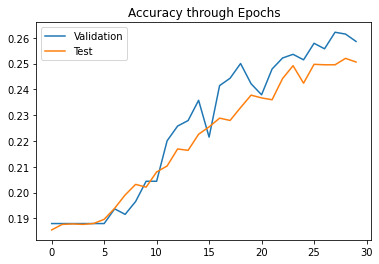

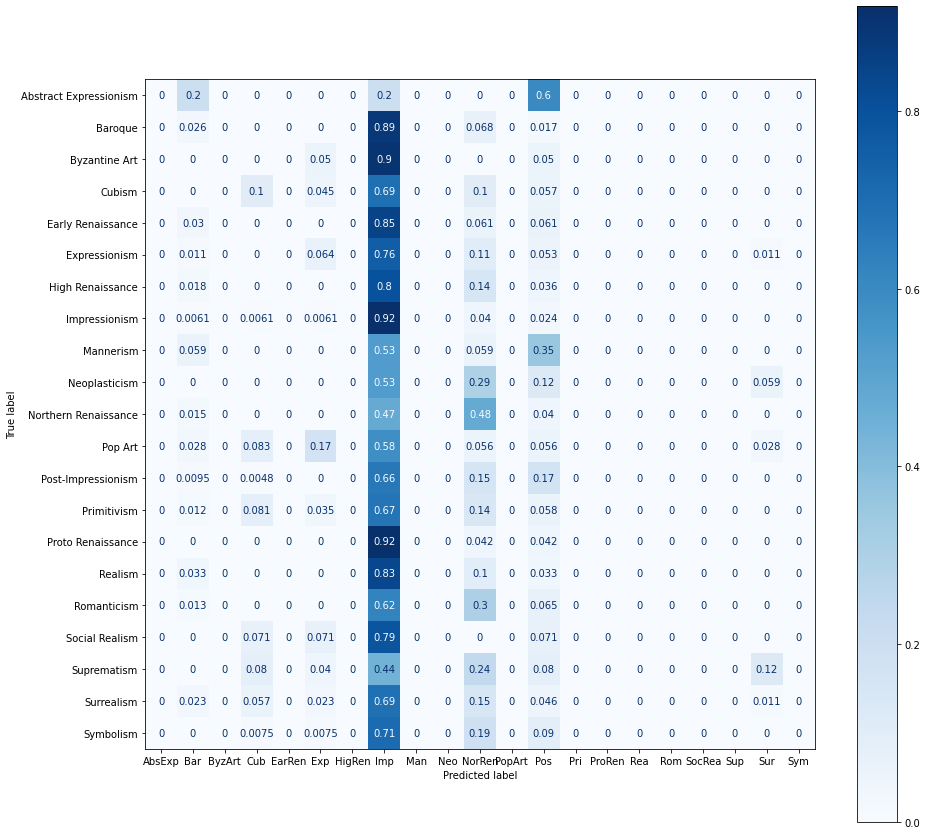

/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Abstract Expressionism       0.00      0.00      0.00         5
               Baroque       0.14      0.03      0.04       117
         Byzantine Art       0.00      0.00      0.00        20
                Cubism       0.29      0.10      0.15        88
     Early Renaissance       0.00      0.00      0.00        33
         Expressionism       0.22      0.06      0.10        94
      High Renaissance       0.00      0.00      0.00       111
         Impressionism       0.24      0.92      0.38       329
             Mannerism       0.00      0.00      0.00        17
         Neoplasticism       0.00      0.00      0.00        17
  Northern Renaissance       0.35      0.48      0.40       202
               Pop Art       0.00      0.00      0.00        36
    Post-Impressionism       0.31      0.17      0.22       210
           Primitivism       0.00      0.00      0.00        86
     Proto Renaissance       0.00      

In [ ]:
fit_eval_save(model, train_dataset, val_dataset, test_dataset, "vgg_vanilla", callbacks, movement_weights)

### Modelo 6

VGG19 (Ultimas 5 Entrenables)  + 2 Capas densas



Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
351/351 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.1831WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe750426d90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

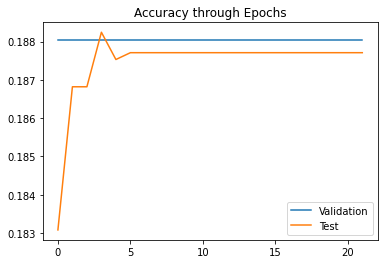

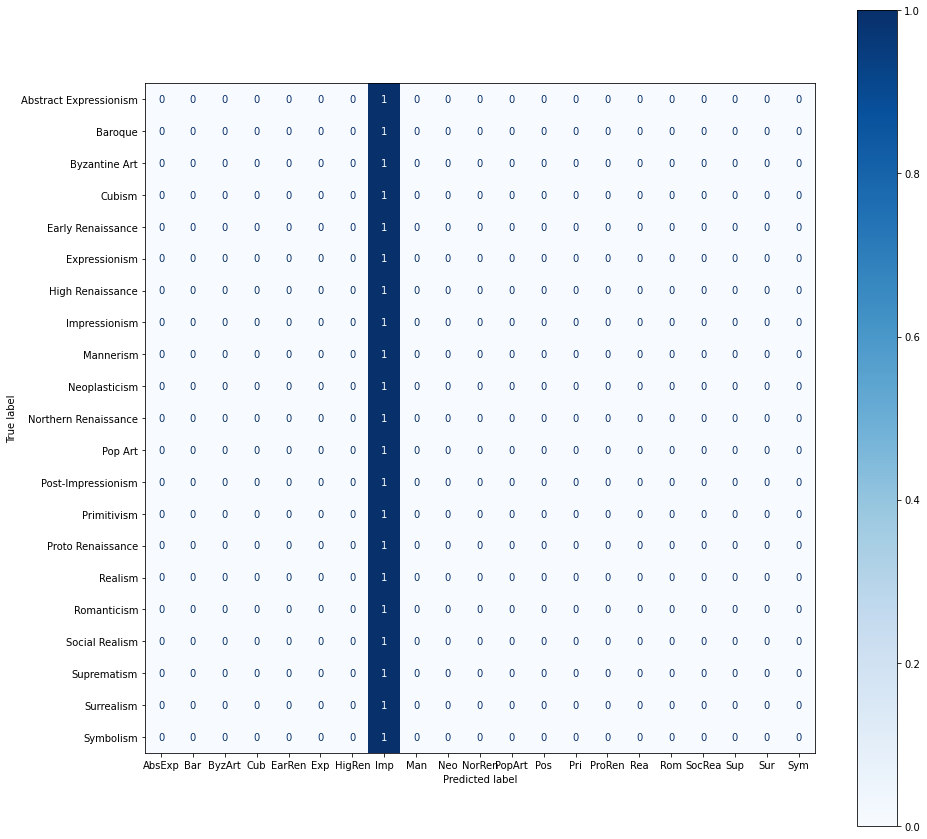

/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Abstract Expressionism       0.00      0.00      0.00         5
               Baroque       0.00      0.00      0.00       117
         Byzantine Art       0.00      0.00      0.00        20
                Cubism       0.00      0.00      0.00        88
     Early Renaissance       0.00      0.00      0.00        33
         Expressionism       0.00      0.00      0.00        94
      High Renaissance       0.00      0.00      0.00       111
         Impressionism       0.19      1.00      0.32       329
             Mannerism       0.00      0.00      0.00        17
         Neoplasticism       0.00      0.00      0.00        17
  Northern Renaissance       0.00      0.00      0.00       202
               Pop Art       0.00      0.00      0.00        36
    Post-Impressionism       0.00      0.00      0.00       210
           Primitivism       0.00      0.00      0.00        86
     Proto Renaissance       0.00      

In [ ]:
base_model.trainable = False

fine_tuning_last = 5 

for layer in base_model.layers[-fine_tuning_last:]:
  layer.trainable = True

model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

fit_eval_save(model, train_dataset, val_dataset, test_dataset, "vgg_last05_tr", callbacks, movement_weights)

### Modelo 7

VGG19 (Ultimas 10 Entrenables)  + 2 Capas densas



Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
351/351 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.1877WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe76e125840> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

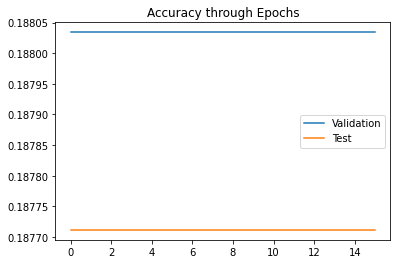

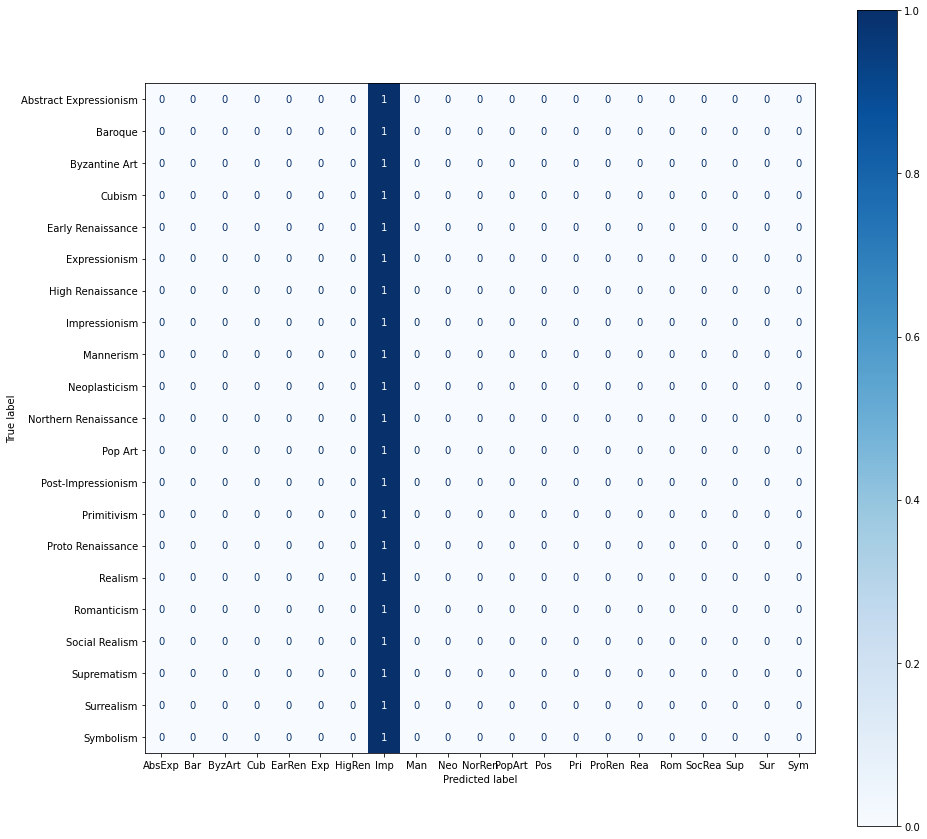

/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Abstract Expressionism       0.00      0.00      0.00         5
               Baroque       0.00      0.00      0.00       117
         Byzantine Art       0.00      0.00      0.00        20
                Cubism       0.00      0.00      0.00        88
     Early Renaissance       0.00      0.00      0.00        33
         Expressionism       0.00      0.00      0.00        94
      High Renaissance       0.00      0.00      0.00       111
         Impressionism       0.19      1.00      0.32       329
             Mannerism       0.00      0.00      0.00        17
         Neoplasticism       0.00      0.00      0.00        17
  Northern Renaissance       0.00      0.00      0.00       202
               Pop Art       0.00      0.00      0.00        36
    Post-Impressionism       0.00      0.00      0.00       210
           Primitivism       0.00      0.00      0.00        86
     Proto Renaissance       0.00      

In [ ]:
base_model.trainable = False

fine_tuning_last = 10

for layer in base_model.layers[-fine_tuning_last:]:
  layer.trainable = True

model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

fit_eval_save(model, train_dataset, val_dataset, test_dataset, "vgg_last10_tr", callbacks, movement_weights)

### Modelo 8

VGG19 (Ultimas 15 Entrenables)  + 2 Capas densas



Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
351/351 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.1877WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe8cc8a1d90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

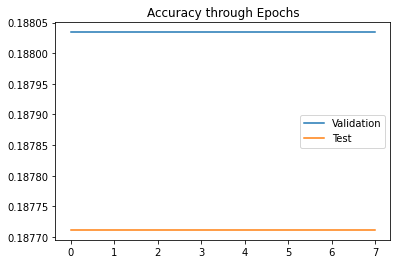

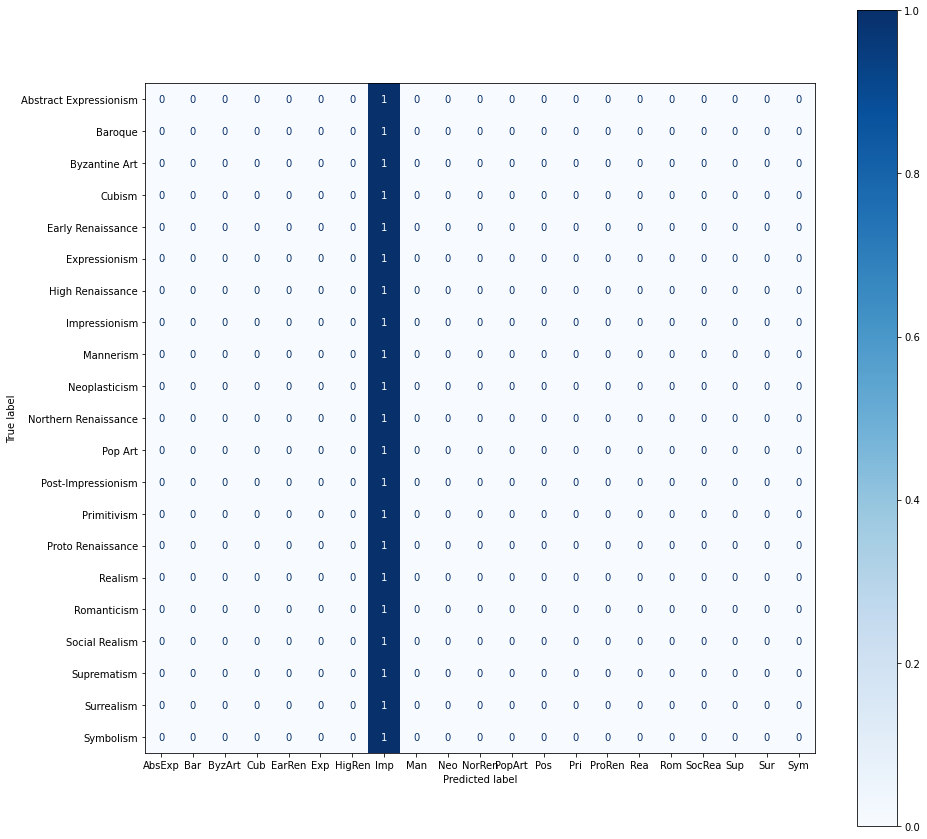

/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Abstract Expressionism       0.00      0.00      0.00         5
               Baroque       0.00      0.00      0.00       117
         Byzantine Art       0.00      0.00      0.00        20
                Cubism       0.00      0.00      0.00        88
     Early Renaissance       0.00      0.00      0.00        33
         Expressionism       0.00      0.00      0.00        94
      High Renaissance       0.00      0.00      0.00       111
         Impressionism       0.19      1.00      0.32       329
             Mannerism       0.00      0.00      0.00        17
         Neoplasticism       0.00      0.00      0.00        17
  Northern Renaissance       0.00      0.00      0.00       202
               Pop Art       0.00      0.00      0.00        36
    Post-Impressionism       0.00      0.00      0.00       210
           Primitivism       0.00      0.00      0.00        86
     Proto Renaissance       0.00      

In [ ]:
base_model.trainable = False

fine_tuning_last = 15

for layer in base_model.layers[-fine_tuning_last:]:
  layer.trainable = True

model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

fit_eval_save(model, train_dataset, val_dataset, test_dataset, "vgg_last15_tr", callbacks, movement_weights)

### Modelo 9

VGG19 (Entrenable)  + 2 Capas densas



Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
351/351 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.1877WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe8b815ae18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

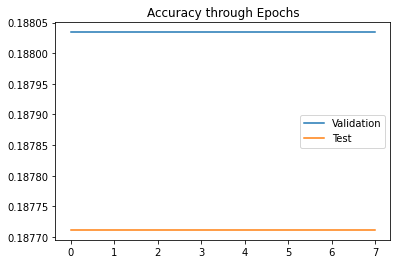

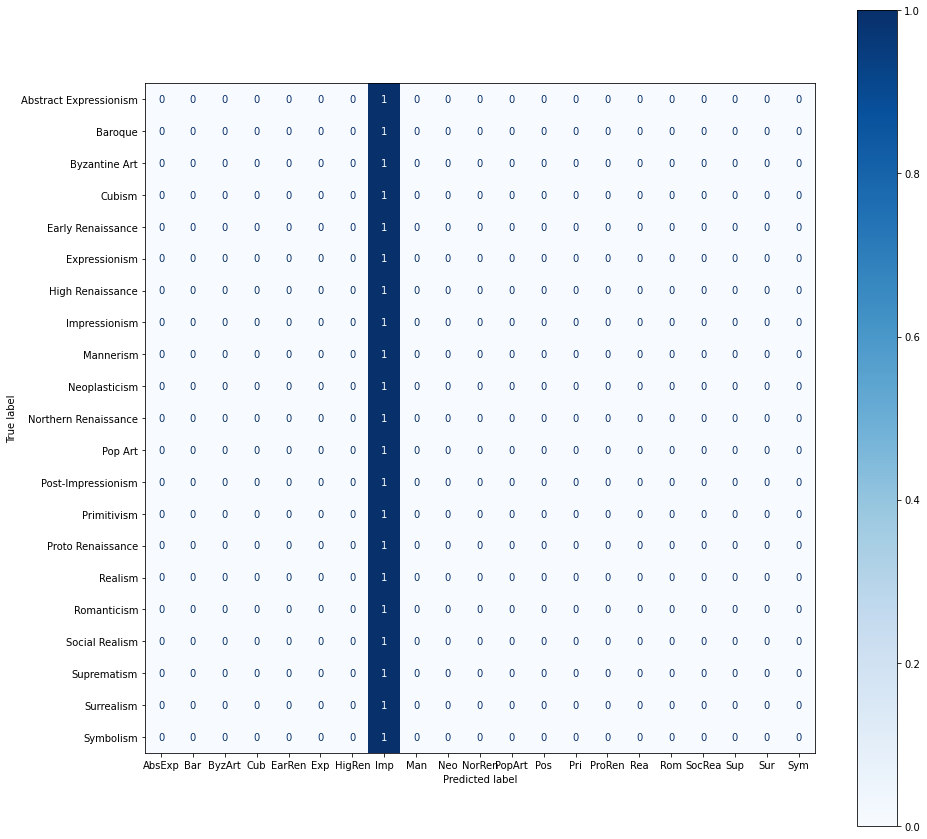

/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Abstract Expressionism       0.00      0.00      0.00         5
               Baroque       0.00      0.00      0.00       117
         Byzantine Art       0.00      0.00      0.00        20
                Cubism       0.00      0.00      0.00        88
     Early Renaissance       0.00      0.00      0.00        33
         Expressionism       0.00      0.00      0.00        94
      High Renaissance       0.00      0.00      0.00       111
         Impressionism       0.19      1.00      0.32       329
             Mannerism       0.00      0.00      0.00        17
         Neoplasticism       0.00      0.00      0.00        17
  Northern Renaissance       0.00      0.00      0.00       202
               Pop Art       0.00      0.00      0.00        36
    Post-Impressionism       0.00      0.00      0.00       210
           Primitivism       0.00      0.00      0.00        86
     Proto Renaissance       0.00      

In [ ]:
base_model.trainable = True

model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

fit_eval_save(model, train_dataset, val_dataset, test_dataset, "vgg_all_tr", callbacks, movement_weights)

# Modelos

De aquí en adelante están los modelos entrenados con más epochs, y con gráficas que permiten comparar la evolución a través de los epochs, y la matriz de confusión del ejercicio de clasificación del conjunto de test, esto con el fin de ubicar si hay algunas clases con mayor predilección de clasificación.

Acá se ven algunas de las predicciones hechas, por el modelo que tuvo mejor accuracy de validación.

In [ ]:
for _ in range(10):
    i = random.randint(1, len(y_test))
    path = test_dataset.filepaths[i]
    gtru = y_test[i]
    pred = y_pred[i]
    img = Image.open(path)
    img.thumbnail((300,300),Image.ANTIALIAS)
    print("-"*40)
    display(img)
    print(f"{os.path.basename(path)}")
    print(f"\tReal: \t\t{clases[gtru]} \n\tPredicha:\t{clases[pred]}")
    
    

